## 1. 라이브러리 설치 및 불러오기  
YOLO 모델을 실행하기 위한 환경을 구성하는 코드입니다.  
필요한 패키지를 설치하고, 이미지 처리 및 데이터 로딩에 필요한 라이브러리를 불러옵니다.

> ✅ 설치 패키지
- `ultralytics`: YOLO 모델 실행 및 학습
- `opencv-python`: 이미지 로딩 및 전처리
- `numpy`, `matplotlib`: 데이터 처리 및 시각화

> ✅ 불러오는 핵심 라이브러리
- `torch`, `torchvision`: 모델 학습 및 데이터 전처리
- `ultralytics.YOLO`: YOLO 모델 로딩
- `cv2`, `numpy`: 이미지 처리 및 수치 계산
- `tqdm`, `matplotlib.pyplot`: 시각화 및 진행 표시

In [1]:
!pip install ultralytics opencv-python numpy matplotlib tqdm pyyaml -q

import os
import cv2
import torch
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.2 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incom

## 2. 랜덤 시드 고정

실험의 일관성을 유지하기 위해 `random`, `numpy`, `torch`의 시드를 고정합니다.  

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_everything()

## 3. 데이터 경로 설정 및 YAML 파일 로드
`data.yaml` 파일을 불러와 학습(train), 검증(val) 데이터의 경로를 설정합니다.

> ✅ 학습 데이터는 모델을 학습시키는 데 사용되며,  
> ✅ 검증 데이터는 학습 중 모델의 성능을 평가하고 과적합 여부를 확인하는 데 사용됩니다.

In [3]:
DATA_YAML_PATH = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/data.yaml"

with open(DATA_YAML_PATH, "r", encoding="utf-8") as f:
    data_yaml = yaml.safe_load(f)

DATASET_PATH = os.path.dirname(DATA_YAML_PATH)
TRAIN_IMAGES = os.path.join(DATASET_PATH, data_yaml["train"].replace("../", ""))
VALID_IMAGES = os.path.join(DATASET_PATH, data_yaml["val"].replace("../", ""))

print(DATASET_PATH)
print(TRAIN_IMAGES)
print(VALID_IMAGES)

/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE
/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images
/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images


## 4. 데이터셋 클래스 정의 및 로드  
객체 탐지 모델을 위한 이미지 데이터셋을 생성하고 불러오는 과정입니다.  
OpenCV와 glob을 활용하여 이미지를 로드하고, torchvision.transforms를 적용해  
크기 변환 및 텐서 변환을 수행합니다.  
마지막으로 샘플 이미지를 시각화하여 데이터가 올바르게 불러와졌는지 확인합니다.

훈련 데이터 샘플


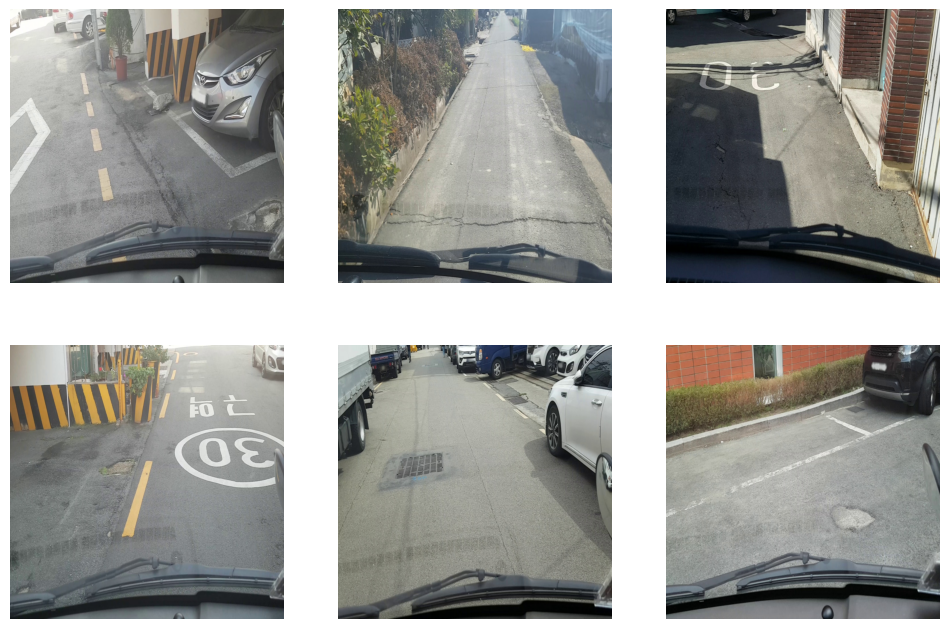

In [4]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob(os.path.join(image_dir, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return self.transform(img) if self.transform else img


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

train_loader = DataLoader(PotholeDataset(TRAIN_IMAGES, transform), batch_size=16, shuffle=True)
valid_loader = DataLoader(PotholeDataset(VALID_IMAGES, transform), batch_size=16, shuffle=False)


def show_sample_images(image_loader):
    sample_images = next(iter(image_loader))

    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    for i, img in enumerate(sample_images[:6]):
        ax[i // 3, i % 3].imshow(img.permute(1, 2, 0).numpy())
        ax[i // 3, i % 3].axis("off")

    plt.show()


print("훈련 데이터 샘플")
show_sample_images(train_loader)

## 5. 랜덤 샘플 시각화 (이미지 + 라벨)

학습 이미지 중 하나를 랜덤으로 선택하여 해당 이미지와 라벨 정보를 시각화합니다.  
라벨은 YOLO 포맷의 좌표 정보를 바탕으로 이미지 위에 바운딩 박스를 그려 확인합니다.


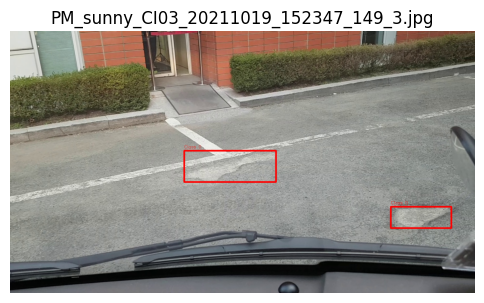

In [5]:
IMAGE_DIR = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images"
IMAGE_PATHS = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))

IMG_PATH = random.choice(IMAGE_PATHS)
LABEL_PATH = IMG_PATH.replace("images", "labels").replace(".jpg", ".txt")

img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

if os.path.exists(LABEL_PATH):
    with open(LABEL_PATH, "r") as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 5)
            cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
else:
    print("라벨 파일이 존재하지 않습니다:", LABEL_PATH)

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(os.path.basename(IMG_PATH))
plt.show()

## 6. YOLO 모델 학습  
YOLO 모델을 불러와 학습을 수행하는 코드입니다.  
데이터셋 경로를 지정하고, 에포크 수 및 배치 크기를 설정하여 학습을 진행합니다.
- 기본적으로 YOLO 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장 경로를 직접 지정해야 합니다.
- `project` 및 `name` 파라미터를 사용하여 원하는 경로에 저장할 수 있습니다.

In [6]:
import time

model = YOLO("yolov8m.pt")

def train_model():
    results = model.train(
        data=DATA_YAML_PATH,
        epochs=10,
        imgsz=320,
        batch=0.85,
        workers=4,
        device="0",
        project="/kaggle/working",
        name="pothole_yolov8m_train"
    )
    return results

start_time = time.time()

results = train_model()

end_time = time.time()
print(f"학습 실행 시간: {end_time - start_time:.2f}초")

100%|██████████| 49.7M/49.7M [00:00<00:00, 210MB/s]


Ultralytics 8.3.128 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=0.85, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pothole_yolov8m_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

100%|██████████| 755k/755k [00:00<00:00, 28.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 59.1±35.2 MB/s, size: 729.9 KB)


train: Scanning /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/labels... 24279 images, 0 backgrounds, 11 corrupt: 100%|██████████| 24290/24290 [02:01<00:00, 200.44it/s]

train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_1124

WARNING ⚠️ train: Cache directory /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=320 at 85.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.25G reserved, 0.24G allocated, 15.40G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25856899       19.77         1.531         47.31           138        (1, 3, 320, 320)                    list
    25856899       39.53         1.753         28.31         77.87        (2, 3, 320, 320)                    list
    25856899       79.07         2.017         29.06         112.7        (4, 3, 320, 320)                    list
  

train: Scanning /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/labels... 24279 images, 0 backgrounds, 11 corrupt: 100%|██████████| 24290/24290 [00:24<00:00, 989.25it/s] 

train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_1124

WARNING ⚠️ train: Cache directory /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.3 ms, read: 22.2±18.1 MB/s, size: 554.1 KB)


val: Scanning /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/labels... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:30<00:00, 197.49it/s]

val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg'


WARNING ⚠️ val: Cache directory /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid is not writeable, cache not saved.
Plotting labels to /kaggle/working/pothole_yolov8m_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005625000000000001), 83 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to /kaggle/working/pothole_yolov8m_train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      9.69G       2.02      1.762       1.18         39        320: 100%|██████████| 338/338 [04:24<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:41<00:00,  1.01it/s]


                   all       5998      15797      0.443      0.294      0.283      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       9.8G       2.04      1.559      1.169         31        320: 100%|██████████| 338/338 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]


                   all       5998      15797      0.455      0.305      0.306      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       9.8G      2.004       1.51      1.155         39        320: 100%|██████████| 338/338 [04:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]


                   all       5998      15797      0.517      0.341      0.353      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      9.79G      1.905      1.394      1.125         36        320: 100%|██████████| 338/338 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]


                   all       5998      15797       0.52       0.36      0.374      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      9.79G      1.794       1.28      1.092         44        320: 100%|██████████| 338/338 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]


                   all       5998      15797      0.589      0.372      0.405      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      9.78G      1.731      1.206      1.074         49        320: 100%|██████████| 338/338 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]


                   all       5998      15797      0.622      0.426      0.476      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      9.78G      1.666      1.127      1.055         28        320: 100%|██████████| 338/338 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]


                   all       5998      15797      0.656      0.468      0.531      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      9.78G      1.598      1.054      1.036         33        320: 100%|██████████| 338/338 [04:20<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]


                   all       5998      15797      0.688      0.495      0.558      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      9.73G      1.542      0.994      1.019         27        320: 100%|██████████| 338/338 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]


                   all       5998      15797      0.709       0.51      0.586      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      9.78G      1.486     0.9309      1.003         22        320: 100%|██████████| 338/338 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]


                   all       5998      15797      0.736      0.523      0.609      0.347

10 epochs completed in 0.842 hours.
Optimizer stripped from /kaggle/working/pothole_yolov8m_train/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/pothole_yolov8m_train/weights/best.pt, 52.0MB

Validating /kaggle/working/pothole_yolov8m_train/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]


                   all       5998      15797      0.735      0.523      0.609      0.347


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/pothole_yolov8m_train
학습 실행 시간: 3352.43초


## 7. 학습 결과 시각화

YOLO 모델 학습 과정에서 저장된 손실 그래프(`results.png`)를 불러와 시각화하는 코드입니다.  
`matplotlib`을 사용하여 이미지를 출력하고, 그래프 외 요소는 제거하여 깔끔하게 보여줍니다.

- 기본적으로 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장된 경로를 명시적으로 지정해주어야 합니다.


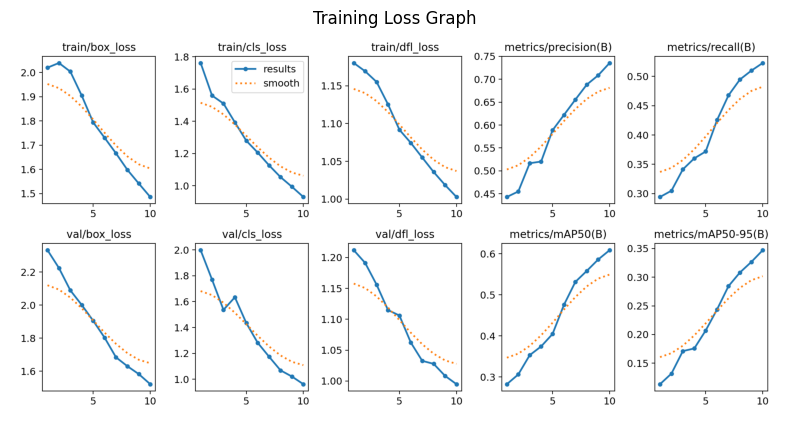

In [7]:
TRAIN_RUN_DIR = "/kaggle/working/pothole_yolov8m_train"
loss_plot_path = f"{TRAIN_RUN_DIR}/results.png"

img = plt.imread(loss_plot_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Training Loss Graph")
plt.show()

## 8. 모델 성능 평가  
학습된 YOLO 모델을 불러와 검증 데이터셋을 이용해 성능을 평가하는 코드입니다.  
`val()` 함수를 사용하여 `mAP`, `Precision`, `Recall` 등의 성능 지표를 계산합니다.

- 캐글 환경에서는 모델이 저장된 경로를 지정해줘야 합니다.


In [8]:
model = YOLO("/kaggle/working/pothole_yolov8m_train/weights/best.pt")

val_results = model.val(data=DATA_YAML_PATH, split="val")

print("검증 데이터 평가 결과:")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")

Ultralytics 8.3.128 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 901.4±305.5 MB/s, size: 721.5 KB)


val: Scanning /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/labels... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:14<00:00, 423.46it/s]

val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg'


WARNING ⚠️ val: Cache directory /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.50it/s]


                   all       5998      15797      0.737      0.522      0.608      0.347


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val
검증 데이터 평가 결과:
mAP50: 0.6082
mAP50-95: 0.3473
Precision: 0.7370
Recall: 0.5219


## 9. 모델 추론 및 시각화
학습된 YOLO 모델을 사용하여 테스트 데이터셋에서 임의의 이미지를 추론합니다.

- 포트홀을 감지하지 못하면 아무것도 표시되지 않습니다.


image 1/1 /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images/PM_wetsunny_CI02_20211021_152554_423_2.jpg: 384x640 (no detections), 42.8ms
Speed: 2.2ms preprocess, 42.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


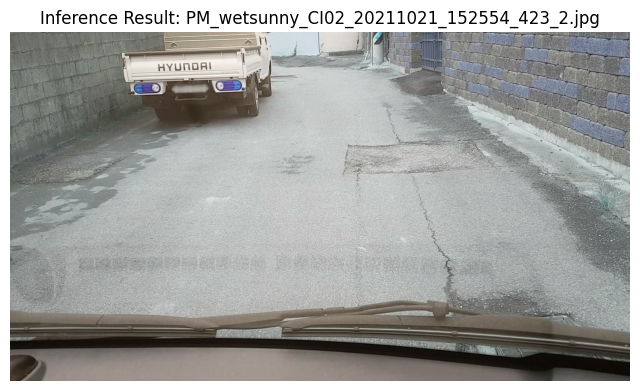

In [9]:
model = YOLO("/kaggle/working/pothole_yolov8m_train/weights/best.pt")

TEST_IMAGE_DIR = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")))
test_img_path = random.choice(test_image_paths)

results = model.predict(source=test_img_path, conf=0.25, imgsz=640, save=False)

result_img = results[0].plot()

plt.figure(figsize=(8, 6))
plt.imshow(result_img)
plt.axis("off")
plt.title(f"Inference Result: {os.path.basename(test_img_path)}")
plt.show()

## 10. 제출 파일 생성 (submission.csv)
테스트 이미지에 대해 학습된 YOLO 모델을 사용하여 객체 탐지를 수행하고,  
예측 결과를 제출 형식에 맞춰 `submission.csv` 파일로 저장합니다.

- 한 이미지당 박스 하나만 제출하며, confidence가 가장 높은 박스를 사용합니다.
- 객체를 감지하지 못한 경우, `ClassId`와 바운딩 박스 좌표는 모두 0으로 처리합니다.
- 이미지가 손상되었거나 열리지 않는 경우에도 에러 없이 넘어가도록 예외 처리를 포함합니다.
- Output 경로인 /kagggle/working/에 저장됩니다.

In [10]:
# import pandas as pd

# model = YOLO("/kaggle/working/pothole_yolov8m_train/weights/best.pt")

# TEST_IMG_DIR = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images"
# test_image_paths = sorted(glob(os.path.join(TEST_IMG_DIR, "*.jpg")))

# submission_rows = []

# for img_path in test_image_paths:
#     image_id = os.path.basename(img_path)

#     if cv2.imread(img_path) is None:
#         print(f"이미지 로드 실패: {image_id}")
#         submission_rows.append({
#             "ImageId": image_id,
#             "ClassId": 0,
#             "X": 0,
#             "Y": 0,
#             "Width": 0,
#             "Height": 0,
#         })
#         continue

#     results = model.predict(source=img_path, conf=0.25, imgsz=640, save=False)
#     result = results[0]

#     if len(result.boxes) > 0:
#         boxes = result.boxes
#         best_idx = boxes.conf.argmax().item()
#         cls_id = int(boxes.cls[best_idx].item())
#         cx, cy, w, h = boxes.xywhn[best_idx].tolist()

#         submission_rows.append({
#             "ImageId": image_id,
#             "ClassId": cls_id,
#             "X": round(cx, 6),
#             "Y": round(cy, 6),
#             "Width": round(w, 6),
#             "Height": round(h, 6),
#         })
#     else:
#         submission_rows.append({
#             "ImageId": image_id,
#             "ClassId": 0,
#             "X": 0,
#             "Y": 0,
#             "Width": 0,
#             "Height": 0,
#         })

# submission_df = pd.DataFrame(submission_rows, columns=["ImageId", "ClassId", "X", "Y", "Width", "Height"])
# submission_path = "/kaggle/working/submission.csv"
# submission_df.to_csv(submission_path, index=False)
# print(f"제출 파일 저장 완료: {submission_path}")